In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import dqr.lobtester.data_providers as data_providers
import dqr.lobtester.postprocessing
import dqr.lobtester.tester as tester

import qpython
import qpython.qconnection

import gc
from tqdm import tqdm

In [2]:
kdb_data_path = "/storage/hdd2/md_tmp_bmll"
# kdb_data_path ='/storage/hdd2/Parsed_BMLL_OIL_Kirill/'
# kdb_data_path = "/storage/hdd2/kdb_bmll_v1.0"
kdb_port = 9000
date = dt.date(2021, 2, 22)
end_date = dt.date(2021, 2, 22)
date_str = dt.datetime.strftime(date, "%Y.%m.%d")
end_date_str = dt.datetime.strftime(end_date, "%Y.%m.%d")
syms = ('BBG000XG00K4',)

In [3]:
q = qpython.qconnection.QConnection('localhost', 9000, pandas=True)
q.open()
q("\\l " + '/storage/hdd2/Parsed_BMLL_OIL_Kirill/')
q('sym')

0    b'BBG00BFJSRV3'
1            b'XNYM'
2    b'BBG003MVLRV3'
3    b'BBG00BFJSQ90'
4    b'BBG003MVLRR8'
dtype: bytes96

In [4]:
x = 0
len_load = 1500000
cont_concat = True
sym = 'BBG00BFJSRV3'

kdb_df = pd.DataFrame(q(f'{x} {len_load} sublist select from mkt_orders where date within (' + date_str + ";" + end_date_str + "), sym=`" + sym))
x += len_load
while cont_concat:
    kdb_df_ = pd.DataFrame(q(f'{x} {len_load} sublist select from mkt_orders where date within (' + date_str + ";" + end_date_str + "), sym=`" + sym))
    kdb_df = pd.concat([kdb_df, kdb_df_])
    x += len_load
    if kdb_df_.shape[0] != len_load:
        cont_concat = False

In [5]:
# DP = {}
# for sym in syms:
#     dp = data_providers.KDBDataProvider()
#     dp.loadData(kdb_data_path, kdb_port, sym, date_str, end_date_str)
#     DP[sym] = dp

In [6]:
# DP.get('BBG000XG00K4').get_data().set_index('exch_time')

In [7]:
def how_many_matching_indexes_are_there(df):
    print( 'number of indexes = ', (pd.Series(df.index) == pd.Series(df.index).shift(1)).sum() )
def how_many_matching_lines_are_there(df):
    print( 'number of lines = ', ((order_book == order_book.shift(1)).all(axis = 1)).sum() )
    

-Can we choose volume levels based on the price grid?

-Does the model calibrated and built on the data (time points) corresponding to the market movement?

-Do we predict that the next trade will move the market up/down? (Or, that n order book levels will break through)

-Do I need to resample the data?

## Data preparation

'b_qty_gr_0’ это volume grid .
Например, а,b,c,d,e,….. - это вот эти значения сетки. 

Например, a = 10000. Тогда говрим: вот вам 10000, дайте мне данный ассет, сколько влезет в эти 10000. То есть наичинаемистощать уровни. Например, были уровни: 
b_px_0  210, b_vol_0  10
b_px_1   200, b_vol_1  20
b_px_2  150, b_vol_0  50
….


Тогда со своими 10000$ остоновимся на уровне b_px_2. Заденем, но не пробьем. Соотв, b_qty_gr_0 будет 150.

Теперь 
'b_vwop_qty_gr_0'
Должно было быть VWAP - volume weighted average price - средневзвешенная цена. 
Тогда также надо знать значения сетки. Пусть a,b,c,d,e…. и a = 10000.
Тогда в данном случае b_vwAp_qty_gr_0 есть цена объема, который можно купить за 10000.
Для нашего примера:
10000 = 210 * 10 + 200 * 20 + 150 * 3900/150. При этом ткупим объем 10+20+3900/150 = 10 + 20 + 26 = 56.
Тогда b_vwop_qty_gr_0 = 10000/56 = 178.57

low_px - есть только у маркет приказов (qtype 1), это цена по которой начался первый трейд

high_px - есть только у маркет приказов, это цена по которой закончился последний трейд

px - vwop цена, (средняя цена в маркет приказа)

qty - объем маркет приказа

trade_count количество трейдов в маркет приказе

trade_dir - направление маркет приказа.

qtype тип данных в строке:
0 - bbo update
1 - trade
2 - deep trade (аномалии в базе bmll)
4 - deep update (update со второго по десятый уровень включительно)

In [8]:
data = kdb_df.set_index('exch_time')

data = data.query('qtype == 1 or qtype == 0')

In [9]:
info_about_market_order = data.columns[:10]
bbo_lvls = data.columns[10:50]
b_px_ = data.columns[10:50:4]
a_px_ = data.columns[10 + 1:50:4]
b_qty_ = data.columns[10 + 2:50:4]
a_qty_ = data.columns[10 + 3:50:4]

In [10]:
term_columns = pd.Index(['qtype', 'trade_dir']).append(bbo_lvls)

## Time to load the parser

In [11]:
# end_of_loading = data.query('abs(b_px_0 - a_px_0) >= 2').shape[0]
# _ = data.iloc[end_of_loading:].duplicated(keep = 'first') 
# end_of_loading = data.iloc[end_of_loading:][_.values].index[3]

In [12]:
end_of_loading = data.iloc[int(5e+03):].index[0]

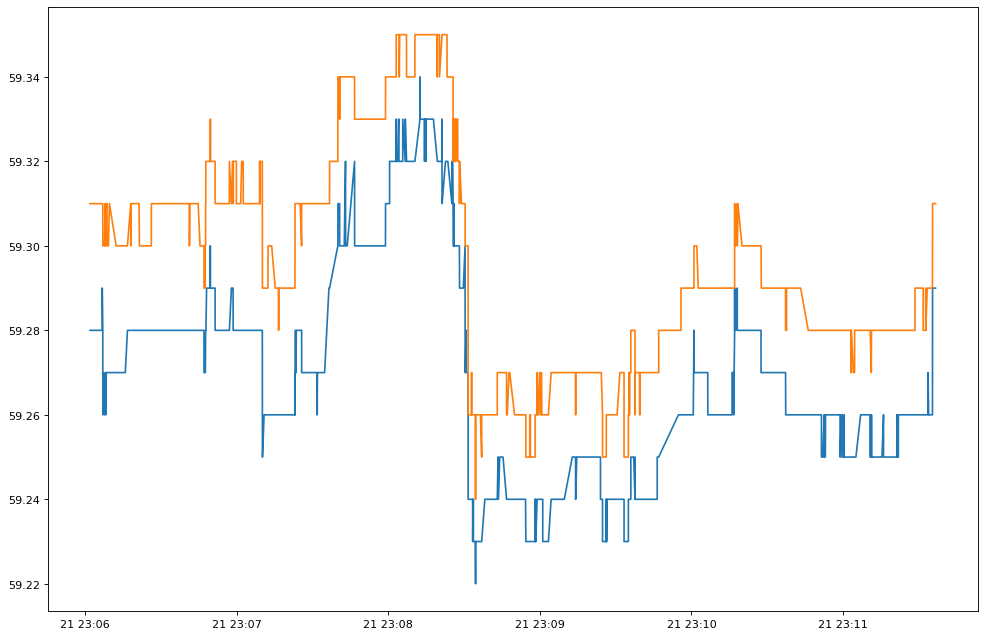

In [13]:
plt.figure(figsize=(15, 10), dpi=80)
plt.plot(data[b_px_[0]].loc[end_of_loading:].iloc[:2000])
plt.plot(data[a_px_[0]].loc[end_of_loading:].iloc[:2000])

In [14]:
term = data.loc[end_of_loading:].iloc[:int(1e+04)]
end_of_loading = term[term.duplicated(keep = 'first') == False].index[1]
data = data.loc[end_of_loading:]

## Getting rid of duplicate events

term_columnsТут происходит фильтрация по состоянию первых 10 уровней стакана и времена событий.

То есть не важно какой тип маркет ивента произошел ('qtype'), если первые 10 уровней стакана не поменялись, то мы считаем, что ПОСЛЕДУЮЩИХ ивентов НЕ БЫЛО!

In [15]:
term_columns[2:6]

Index(['b_px_0', 'a_px_0', 'b_qty_0', 'a_qty_0'], dtype='object')

In [16]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 10) 

hm = data.loc[:,term_columns[2:6]]
hm['exch_time'] = data.index

In [17]:
d_bbo_updates = hm.duplicated(keep = 'first')

In [18]:
d_bbo_updates.sum()

11

In [19]:
data_ud_bbo = data[d_bbo_updates == False]

In [20]:
data_ud_bbo.shape

(3500895, 140)

In [21]:
del data
gc.collect()

13253

In [22]:
# # data_ud_bbo_ud = data_ud_bbo[data_ud_bbo.index.duplicated(keep = False) == False]
# # data_ud_bbo_d = data_ud_bbo[data_ud_bbo.index.duplicated(keep = False)]

# data_ud_bbo_d = data_ud_bbo[data_ud_bbo.index.duplicated(keep = False)]

# data_ud_bbo_d['qtype'].loc[:,term_columns[:]]

## Determining the market movement

In [23]:
def detect_market_move(x):
    if x > 0:
        return 1
    if x < 0:
        return -1
    if x == 0:
        return 0

In [24]:
mpx = (data_ud_bbo['b_px_0'] + data_ud_bbo['a_px_0']) / 2

In [25]:
data_ud_bbo['market_move'] = (mpx - mpx.shift(1)).apply(detect_market_move).fillna(0)

In [26]:
del mpx
gc.collect()

0

In [27]:
# # data = DP.get('BBG000XG00K4').get_data().set_index('exch_time')

# columns = data.columns.to_list()

# data = data.drop(data.index[data.index.duplicated(keep = 'last')])

# order_book = data[columns[15:55]]
# order_book = order_book.drop(order_book.index[((order_book == order_book.shift(1)).all(axis = 1))])

In [28]:
# how_many_matching_lines_are_there(order_book)
# how_many_matching_indexes_are_there(order_book)

Select the desired columns

In [29]:
# info_about_market_order = data.columns[:10]
# bbo_lvls = data.columns[10:50]
# b_px_ = data.columns[10:50:4]
# a_px_ = data.columns[10 + 1:50:4]
# b_qty_ = data.columns[10 + 2:50:4]
# a_qty_ = data.columns[10 + 3:50:4]

In [30]:
b_columns = b_px_.append(b_qty_)
b_px_columns = b_px_
b_qty_columns = b_qty_

a_columns = a_px_.append(a_qty_)
a_px_columns = a_px_
a_qty_columns = a_qty_

qty_columns = b_qty_.append(a_qty_)

## Plotting a histogram of the volume distribution by order book levels

In [31]:
order_book = data_ud_bbo.loc[:,bbo_lvls]

In [32]:
data_ud_bbo.query('qtype == 1').shape[0]

18936

In [33]:
sum_qty_order_book = order_book[qty_columns].sum()

sum_qty = sum_qty_order_book.sum()

gist = sum_qty_order_book / sum_qty
gist_a = gist[:10].reset_index(drop = True)
gist_b = gist[10:].reset_index(drop = True)

In [34]:
# gist_a = pd.DataFrame({'qty': gist_a.to_list(),'lvl': np.arange(10)})
# gist_b = pd.DataFrame({'qty': gist_b.to_list(),'lvl': np.arange(10)})

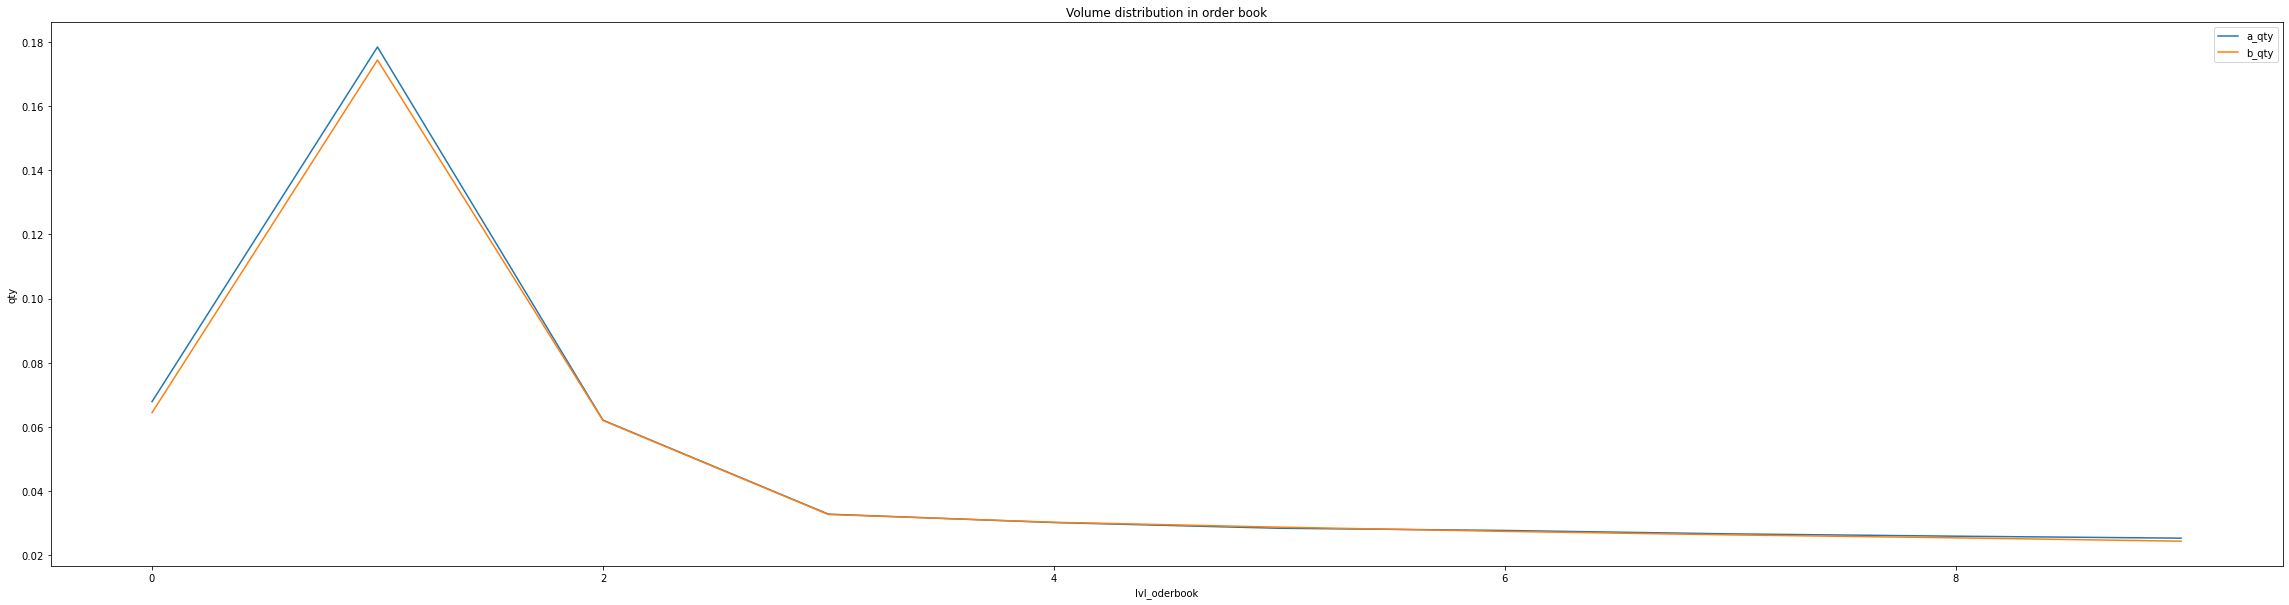

In [35]:
plt.figure(figsize=(40, 10))
plt.title('Volume distribution in order book')
plt.xlabel("lvl_oderbook")
plt.ylabel("qty")
plt.plot(gist_a, label='a_qty')
plt.plot(gist_b, label='b_qty')
plt.legend()

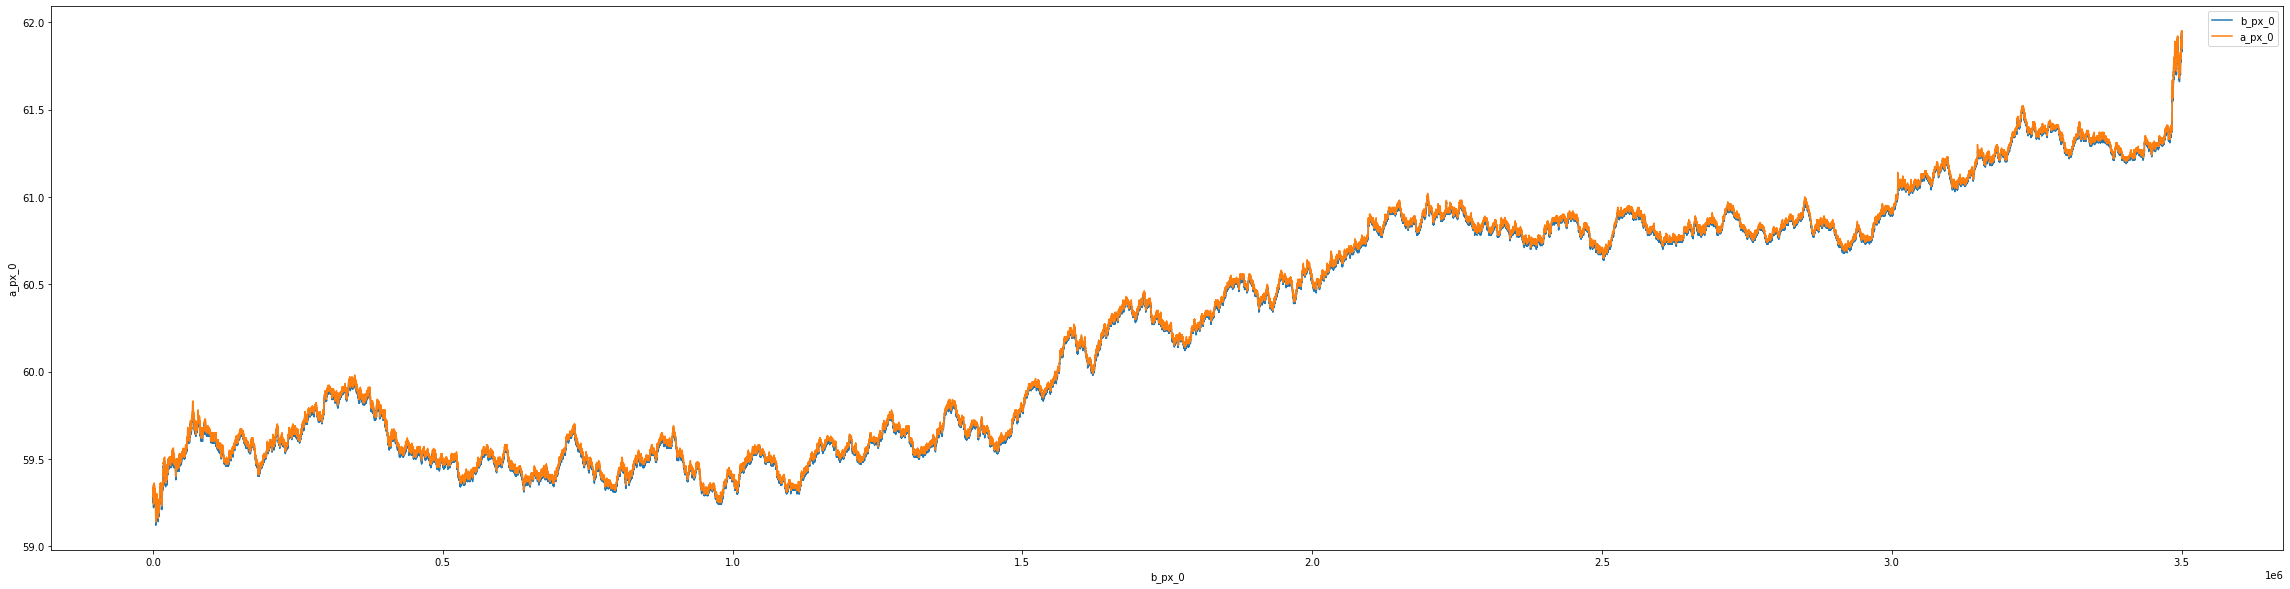

In [45]:
plt.figure(figsize=(40, 10))
plt.xlabel("b_px_0")
plt.ylabel("a_px_0")
plt.plot(data_ud_bbo['b_px_0'].reset_index(drop = True), label='b_px_0')
plt.plot(data_ud_bbo['a_px_0'].reset_index(drop = True), label='a_px_0')
plt.legend()

In [37]:
del gist_a, gist_b
gc.collect()

0

We can conclude that the main volume falls on the first three levels of the order book

## Calibrating the model

### Сalibration of the correlation coefficient

In [38]:
import numpy as np
import pandas as pd

import dqr.strategies
import dqr.lobtester.numbed_strategy as numbed_strategy
import dqr.utilities
from numba.typed import List
import dqr.strategies


def getStrategy(syms, config):
    return BMStrategy(syms, config)

class BMStrategy(dqr.strategies.Strategy):
    def __init__(self, config):
#         assert len(syms) == 2, 'Must have exactly two syms'
        self.__syms = tuple(['BBG00BFJSRV3'])
        self.__window = config['window'] if 'window' in config else '60s'
        self.__barrier_up = config['barrier_up'] if 'barrier_up' in config else 0.85
        self.__barrier_down = config['barrier_down'] if 'barrier_down' in config else 0.25
#         self.__beta = config['beta']
        self.__inverted = config['inverted'] if 'inverted' in config else False

    def prepare_data(self): # CAN BE CHANGED
        q = qpython.qconnection.QConnection('localhost', 4332, pandas=True)
        q.open()
        q("\\l " + '/storage/hdd2/Parsed_BMLL_OIL_Kirill/')
        
        date = dt.date(2021, 2, 22)
        end_date = dt.date(2021, 2, 22)
        date_str = dt.datetime.strftime(date, "%Y.%m.%d")
        end_date_str = dt.datetime.strftime(end_date, "%Y.%m.%d")
        
        x = 0
        len_load = 1500000
        cont_concat = True

        self.kdb_df = pd.DataFrame(q(f'{x} {len_load} sublist select from mkt_orders where date within (' + date_str + ";" + end_date_str + "), sym=`" + self.__syms[0]))
        x += len_load
        while cont_concat:
            kdb_df_ = pd.DataFrame(q(f'{x} {len_load} sublist select from mkt_orders where date within (' + date_str + ";" + end_date_str + "), sym=`" + self.__syms[0]))
            self.kdb_df = pd.concat([self.kdb_df, kdb_df_])
            x += len_load
            if kdb_df_.shape[0] != len_load:
                cont_concat = False
        
        data = self.kdb_df.set_index('exch_time')
        data = data.query('qtype == 1 or qtype == 0')
        
        self.info_about_market_order = data.columns[:10]
        self.bbo_lvls = data.columns[10:50]
        self.b_px_ = data.columns[10:50:4]
        self.a_px_ = data.columns[10 + 1:50:4]
        self.b_qty_ = data.columns[10 + 2:50:4]
        self.a_qty_ = data.columns[10 + 3:50:4]
        
        term_columns = pd.Index(['qtype', 'trade_dir']).append(bbo_lvls)
        end_of_loading = data.iloc[int(5e+03):].index[0]
        
        term = data.loc[end_of_loading:].iloc[:int(1e+04)]
        end_of_loading = term[term.duplicated(keep = 'first') == False].index[1]
        data = data.loc[end_of_loading:]
        
        pd.set_option('display.max_columns', None) 
        pd.set_option('display.max_rows', 10) 

        hm = data.loc[:,term_columns[2:6]]
        hm['exch_time'] = data.index
        
        d_bbo_updates = hm.duplicated(keep = 'first')
        data_ud_bbo = data[d_bbo_updates == False]
        
        del data
        gc.collect()
        
        self.b_columns = b_px_.append(b_qty_)
        self.b_px_columns = b_px_
        self.b_qty_columns = b_qty_

        self.a_columns = a_px_.append(a_qty_)
        self.a_px_columns = a_px_
        self.a_qty_columns = a_qty_

        self.qty_columns = b_qty_.append(a_qty_)
        
        return data_ud_bbo

    def calibrate(self, DP, split_index):
        pass
    
    def get_col_minus_facmean(self, x, factors_mean = 0):
        return x - factors_mean
    def get_col_div_absfacmean(self, x, abs_factors_mean = 0):
        return x / abs_factors_mean
    
    def get_position(self, DP): # MUST BE CHANGED
        data_ud_bbo = self.prepare_data(DP)
        
        order_book = data_ud_bbo.loc[:, self.bbo_lvls]
        number_lvls_orderbook = 1
        a_qty = order_book[self.a_qty_columns[:number_lvls_orderbook]].sum(axis = 1)
        b_qty = order_book[self.b_qty_columns[:number_lvls_orderbook]].sum(axis = 1)
        
        delta_a_qty = (a_qty - a_qty.shift(1))
        delta_b_qty = (b_qty - b_qty.shift(1))
        
        window = self.__window
        rho = delta_b_qty.rolling(window).corr(delta_a_qty)
        # rho = delta_b_qty.rolling(window).corr(delta_a_qty)
        rho.describe()
        
        P_up = (0.5) * (1 - np.arctan( np.sqrt((1 + rho) / (1 - rho)) * (a_qty - b_qty) / (b_qty + a_qty) ) /\
                np.arctan( np.sqrt((1 + rho) / (1 - rho)) ))
        
        P_down = (0.5) * (1 - np.arctan( np.sqrt((1 + rho) / (1 - rho)) * (b_qty - a_qty) / (b_qty + a_qty) ) /\
                np.arctan( np.sqrt((1 + rho) / (1 - rho)) ))
        
        signal_buy = P_up >= self.__barrier_up
        signal_sell = P_up < self.__barrier_down

        position = np.zeros(len(data_ud_bbo))
        position[:] = np.nan
        position[np.where(signal_sell)] = -1
        position[np.where(signal_buy)] = 1
        position[0] = 0
        
        dictionary = {}        
        for i, asset_name in enumerate(self.__syms):
            asset_col = f'px_{i + 1}'
            df_term = DP.get(asset_name).get_data()[['exch_time', 'px']]
            df_term = pd.merge_asof(df_term,
                                    factors[asset_col],
                                    left_on='exch_time',
                                    right_index = True
                                    ).fillna(method='ffill').fillna(0)
            
            if self.__inverted == True:
                dictionary[asset_name] = np.array(-df_term[asset_col],
                                                  dtype = np.float32
                                                 )
                
            else: 
                dictionary[asset_name] = np.array(df_term[asset_col],
                                                    dtype = np.float32
                                                   )
        return dictionary
    
    def filtering(self, df, column_name = 'px'):
        '''
        Input:
        df - Data Frame, what we will filter,
        column_name - the column that is being filtered by
        Output: 
        Bool indexes of the original Data Frame that survived filtering
        '''
        ret = df[column_name] - df[column_name].shift(1)
        ret_std = ret.ewm(span = 10).std().fillna(0)
        return abs(ret_std) < 10 * ret_std.mean()
    
    @property
    def syms(self):
        return self.__syms
    
    def get_numbed_strategy(self, dp):
        position_dict = self.get_position(dp)
        nb_strategy = numbed_strategy.NumbedStrategy()

        for provider in dp.values():
            sym = provider.get_sym()
            if sym in self.__syms:
                time = List(provider.get_time())
                position = List(position_dict[sym])
                container = numbed_strategy.DesiredPositionChangeEventsContainer()
                container.add_time_series(time, position, sym)
                nb_strategy.append_data_to_dict(sym, container)
        return nb_strategy

In [39]:
number_lvls_orderbook = 1
a_qty = order_book[a_qty_columns[:number_lvls_orderbook]].sum(axis = 1)
b_qty = order_book[b_qty_columns[:number_lvls_orderbook]].sum(axis = 1)

In [40]:
delta_a_qty = (a_qty - a_qty.shift(1))
delta_b_qty = (b_qty - b_qty.shift(1))

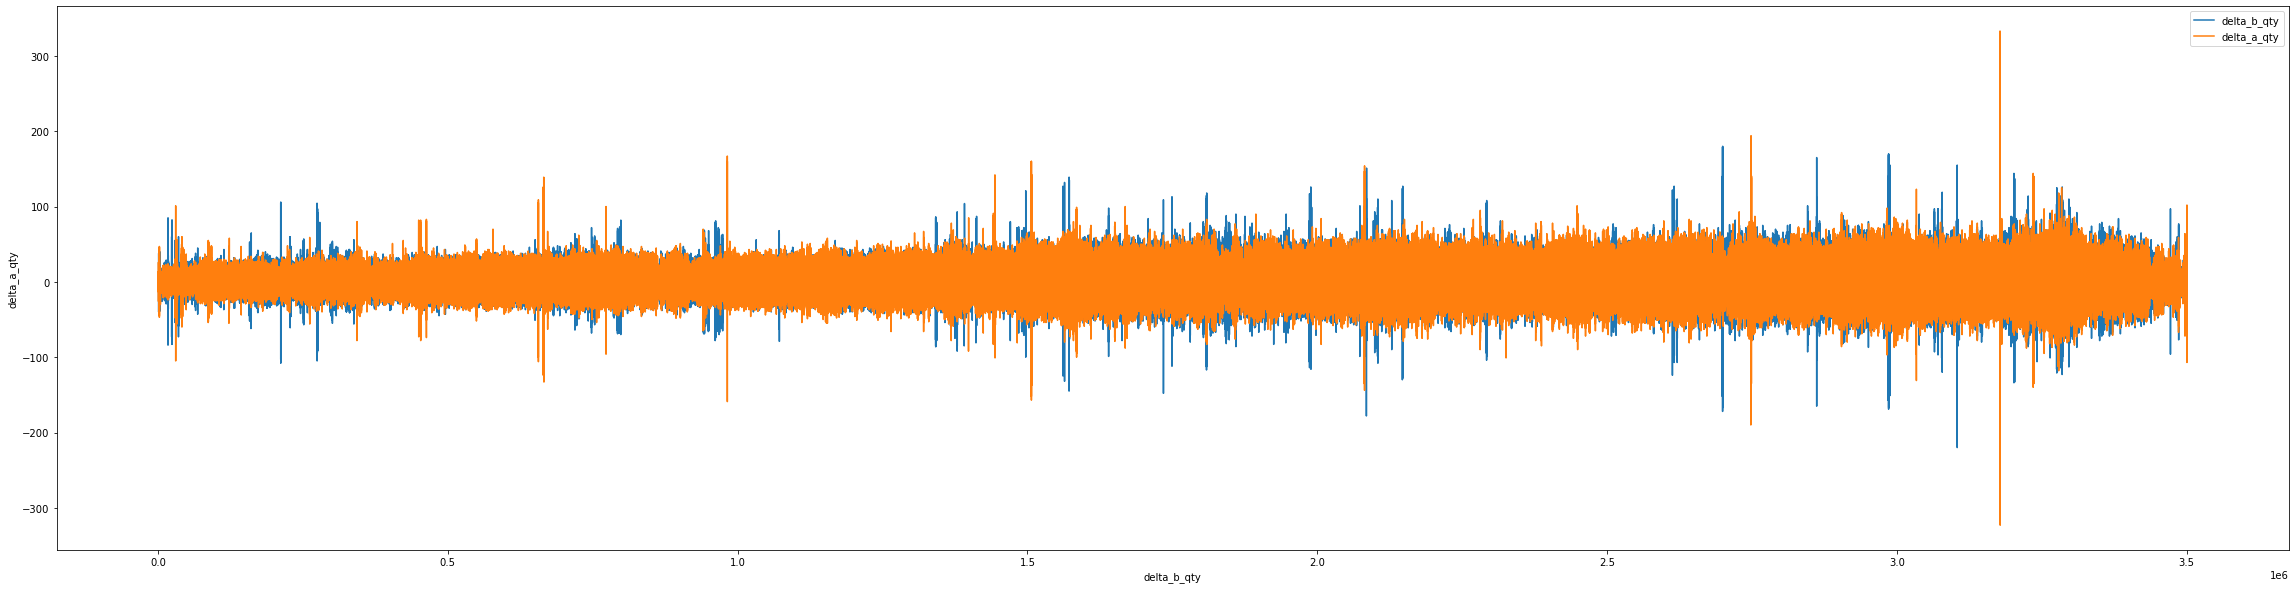

In [1325]:
plt.figure(figsize=(40, 10))
plt.xlabel("delta_b_qty")
plt.ylabel("delta_a_qty")
delta_a_qty_ = delta_a_qty
delta_b_qty_ = delta_b_qty
plt.plot(delta_a_qty_.reset_index(drop = True), label='delta_b_qty')
plt.plot(delta_b_qty_.reset_index(drop = True), label='delta_a_qty')
plt.legend()

#### Checking for stationarity

In [49]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf

In [55]:
def get_adfuller_results(X, get_result = False):
    ar = adfuller(X)
    pvalue = ar[1]
    score = ar[0]
    crit = ar[4]['5%']
    print("p-value = {}".format(ar[1]),
          "score = {}".format(ar[0]),
          "crit 5% = {}".format(ar[4]['5%'])
         )
    if get_result:
        return pvalue, score, crit

In [56]:
def get_ljung_box_results(X, get_result = False):
    qq_test = acf(X, qstat=True, nlags = len(X), fft=False)
    print(pd.DataFrame({'Q-stat': qq_test[1], 'p-value': qq_test[2]}))
    if get_result:
        return qq_test[1], qq_test[2]

In [58]:
get_adfuller_results(delta_a_qty.iloc[:100000].dropna())

p-value = 0.0 score = -57.26508165896535 crit 5% = -2.861568923670306


In [59]:
get_adfuller_results(delta_b_qty.iloc[:100000].dropna())

p-value = 0.0 score = -53.621712684470864 crit 5% = -2.861568923670306


The Dickie Fuller criterion rejects the null hypothesis that there is a unit root

In [61]:
get_ljung_box_results(delta_b_qty.iloc[:100000].dropna())

              Q-stat        p-value
0         936.503221  1.139285e-205
1        1623.795575   0.000000e+00
2        1916.930893   0.000000e+00
3        2110.678247   0.000000e+00
4        2186.224889   0.000000e+00
...              ...            ...
99993  106298.839708   1.047994e-43
99994  106298.850772   1.080344e-43
99995  106298.865536   1.113564e-43
99996  106298.887661   1.147549e-43
99997  106298.931953   1.181785e-43

[99998 rows x 2 columns]


The hypothesis of randomness of the series is not rejected, and most likely this process is not white noise.

### Сalibrate the correlation coefficient

In [41]:
# window = 10000
window = '60s'
rho = delta_b_qty.rolling(window).corr(delta_a_qty)
# rho = delta_b_qty.rolling(window).corr(delta_a_qty)
rho.describe()

count    3.500893e+06
mean     2.036223e-02
std      1.588964e-02
min     -1.000000e+00
25%      1.480083e-02
50%      1.965541e-02
75%      2.580423e-02
max      4.994219e-01
dtype: float64

In [42]:
sigma_b = delta_b_qty.rolling(window).std()
sigma_a = delta_a_qty.rolling(window).std()

In [44]:
sigma_a.describe()

count    3.500893e+06
mean     4.747615e+00
std      1.493225e+00
min      2.357023e-01
25%      3.801115e+00
50%      4.623281e+00
75%      5.510447e+00
max      2.911273e+01
dtype: float64

In [45]:
sigma_b.describe()

count    3.500893e+06
mean     4.866485e+00
std      1.450499e+00
min      5.510580e-01
25%      3.925746e+00
50%      4.812097e+00
75%      5.642522e+00
max      1.675819e+01
dtype: float64

In [46]:
sigma_b = delta_b_qty.rolling(window).std().mean()
sigma_a = delta_a_qty.rolling(window).std().mean()

In [ ]:
# from datetime import timedelta
# delta = timedelta(
#      days=0,
#      seconds=0,
#      microseconds=0,
#      milliseconds=0,
#      minutes=5,
#      hours=0,
#      weeks=0
# )

### Get the probability up_tick

In [904]:
P_up = (0.5) * (1 - np.arctan( np.sqrt((1 + rho) / (1 - rho)) * (a_qty / sigma_a  - b_qty / sigma_b ) / (b_qty / sigma_b + a_qty / sigma_a ) ) /\
                np.arctan( np.sqrt((1 + rho) / (1 - rho)) ))

In [64]:
P_down = (0.5) * (1 - np.arctan( np.sqrt((1 + rho) / (1 - rho)) * (b_qty / sigma_b  - a_qty / sigma_a ) / (b_qty / sigma_b + a_qty / sigma_a ) ) /\
                np.arctan( np.sqrt((1 + rho) / (1 - rho)) ))

In [ ]:
# term = DP.get('BBG000XG00K4').get_data().set_index('exch_time')[['qtype','trade_dir' ,'a_px_0','a_px_3',
#  'b_px_0','b_px_3']]

# index_b_upticks = term[(term['b_px_3'] >= term['b_px_0'].shift(1))].index
# index_a_upticks = term[(term['a_px_0'] >= term['a_px_3'].shift(1))].index

In [49]:
# market_move = pd.concat([data_ud_bbo['market_move'], P_up.shift(1)], axis=1).dropna()
# market_move.rename(columns={0: 'P_up'}, inplace=True)

In [50]:
lvls_orderbook = ['qtype', 'trade_dir','a_px_0', f'a_px_{number_lvls_orderbook}', 'b_px_0', f'b_px_{number_lvls_orderbook}','market_move']

In [51]:
# lvls_orderbook = [a_px_columns[:number_lvls_orderbook].to_list()]
# lvls_orderbook.append(b_px_columns[:number_lvls_orderbook].to_list())
# lvls_orderbook = sum(lvls_orderbook,[])
market_move = data_ud_bbo[lvls_orderbook]
market_move = pd.concat([market_move, P_up.shift(1)], axis=1)
market_move.rename(columns={0: 'P_up'}, inplace=True)

market_move.loc[:,'P_up'] = P_up

market_move

,qtype,trade_dir,a_px_0,a_px_1,b_px_0,b_px_1,market_move,P_up
exch_time,,,,,,,,
2021-02-21 23:06:02.036195517,0,-1,59.31,59.32,59.28,59.27,0.0,NaN
2021-02-21 23:06:02.037445023,0,-1,59.31,59.32,59.28,59.27,0.0,NaN
2021-02-21 23:06:02.037953467,0,-1,59.31,59.32,59.28,59.27,0.0,NaN
2021-02-21 23:06:02.038158767,0,-1,59.31,59.32,59.28,59.27,0.0,0.383784
2021-02-21 23:06:02.256036601,0,1,59.31,59.32,59.28,59.27,0.0,0.304622
...,...,...,...,...,...,...,...,...
2021-02-22 21:59:59.855510645,0,1,61.93,61.94,61.90,61.89,0.0,0.968165
2021-02-22 22:00:00.000000000,0,-1,61.93,61.94,61.90,61.89,0.0,0.967146
2021-02-22 22:00:00.000000000,0,1,61.93,61.94,61.90,61.89,0.0,0.993448


In [65]:
market_move['P_down'] = P_down

In [ ]:
ud_indexes = market_move.index.duplicated(keep = 'last')
data_qtype_1 = market_move.query('qtype == 1')

In [ ]:
ud_exch_time_market_move = market_move.loc[ud_indexes == False]

In [ ]:
ud_exch_time_market_move

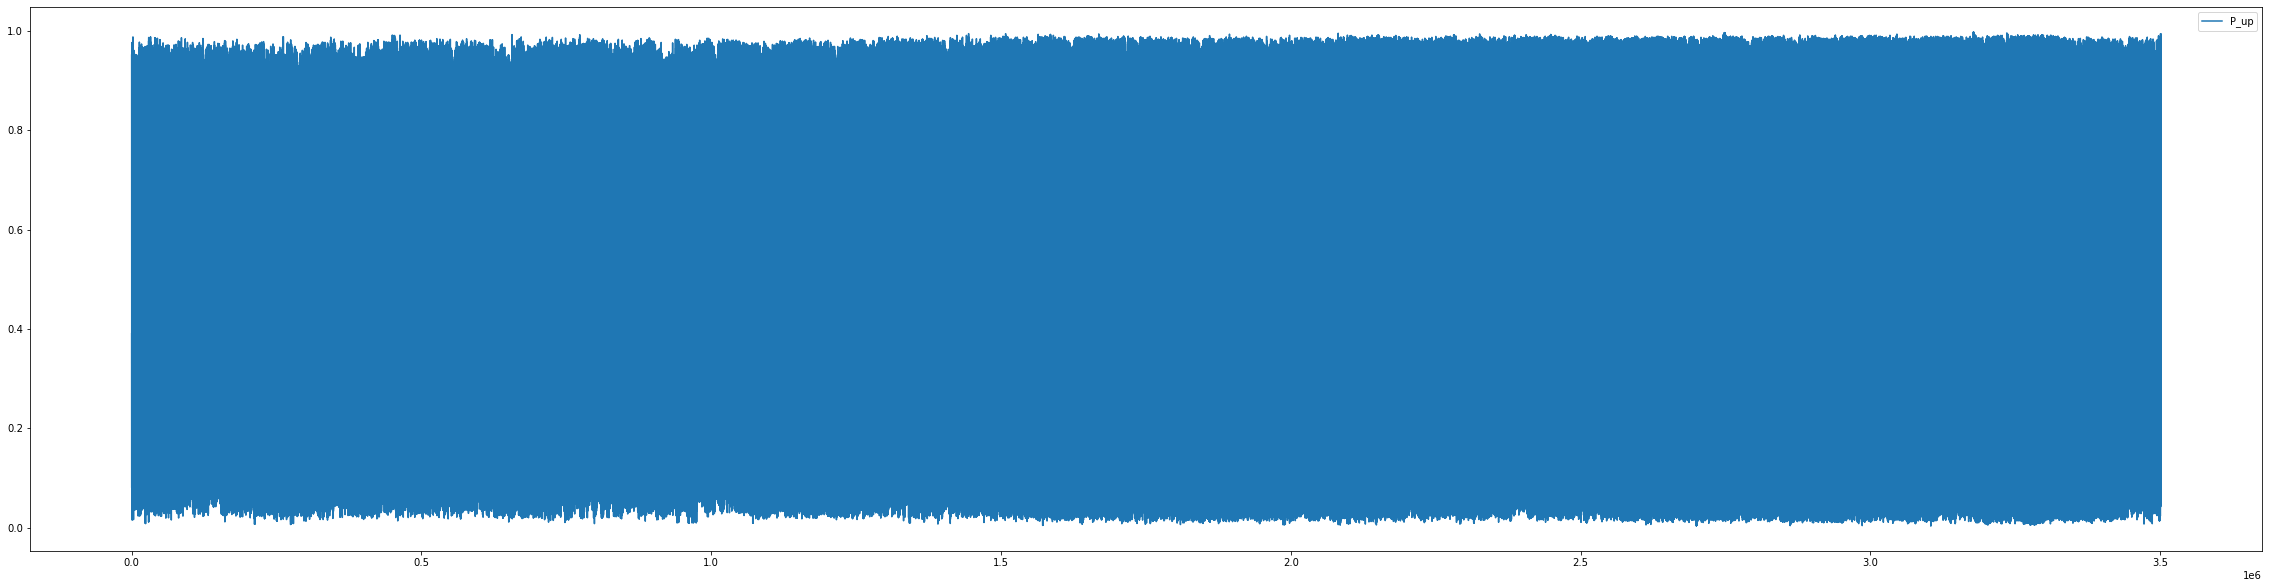

In [72]:
plt.figure(figsize=(40, 10))
plt.plot(market_move['P_up'].reset_index(drop = True), label='P_up')
plt.legend()

In [52]:
from numba import njit

@njit
def get_first_up_tick(market_move, value):
    for i in range(len(market_move)):
        if market_move[i] >= value:
            return i
    return -1
@njit
def get_first_down_tick(market_move, value):
    for i in range(len(market_move)):
        if market_move[i] <= value:
            return i
    return -1

In [ ]:
market_move['tick'] = np.nan
for i in tqdm(range(market_move.shape[0]), bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'):
    up_tick = int( get_first_up_tick(market_move.loc[:, 'a_px_0'].iloc[i:].values,
                                     market_move.loc[:, f'a_px_{number_lvls_orderbook}'].iloc[i]) )
    down_tick = int( get_first_down_tick(market_move.loc[:, 'b_px_0'].iloc[i:].values,
                                         market_move.loc[:, f'b_px_{number_lvls_orderbook}'].iloc[i]) )

    while up_tick == down_tick and up_tick != -1:
        up_tick += int( get_first_up_tick(market_move.loc[:, 'a_px_0'].iloc[i + up_tick:].values,
                                          market_move.loc[:, f'a_px_{number_lvls_orderbook}'].iloc[i]) )
        down_tick += int( get_first_down_tick(market_move.loc[:, 'b_px_0'].iloc[i + down_tick:].values,
                                              market_move.loc[:, f'b_px_{number_lvls_orderbook}'].iloc[i]) )

    if (up_tick != -1 and down_tick == -1) or up_tick < down_tick:
        market_move.loc[:,'tick'].iloc[i] = 1
    if (up_tick == -1 and down_tick != -1) or up_tick > down_tick:
        market_move.loc[:,'tick'].iloc[i] = -1
    if up_tick == -1 and down_tick == -1:
        market_move.loc[:,'tick'].iloc[i] = np.nan

  0%|                    | 0/3500895 [00:00<?, ?it/s]/home/kormis/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 97%|███████████████████▎| 3385579/3500895 [37:32<01:08, 1674.54it/s] 

In [ ]:
# market_move['tick'] = np.nan
# for i in range(len(market_move)):
#     up_ticks = market_move.iloc[i:][(market_move['a_px_0'].iloc[i:] >= market_move.iloc[i]['a_px_3'])]
#     down_ticks = market_move.iloc[i:][(market_move['b_px_0'].iloc[i:] <= market_move.iloc[i]['b_px_3'])]
#     if len(up_ticks) != 0 and len(down_ticks) != 0:
#         if up_ticks.index[0] == down_ticks.index[0]:
#             up_ticks.index[0] == up_ticks.index[1]
#             down_ticks.index[0] == down_ticks.index[1]
#         if up_ticks.index[0] < down_ticks.index[0]:
#             market_move['tick'].iloc[i] = 1
#         if up_ticks.index[0] > down_ticks.index[0]:
#             market_move['tick'].iloc[i] = -1
#     elif len(up_ticks) != 0:
#         market_move['tick'].iloc[i] = 1
#     elif len(down_ticks) != 0:
#         market_move['tick'].iloc[i] = -1

In [66]:
def function_test(market_move, barrier_up = 0.5, barrier_down = 0.5, beta = 1):

    tp = market_move.query('tick == 1 and P_up > @barrier_up').shape[0]
    tn = market_move.query('tick == -1 and P_down < @barrier_down').shape[0]
    fp = market_move.query('tick == -1 and P_up > @barrier_up').shape[0]
    fn = market_move.query('tick == 1 and P_down < @barrier_down').shape[0]
    
#     count_upticks = (market_move.loc[:,'tick'] > 0).sum()
    count_upticks = market_move.query('tick == 1').shape[0]
#     count_downticks = (market_move.loc[:,'tick'] < 0).sum()
    count_upticks = market_move.query('tick == -1').shape[0]
    count_ticks = market_move.shape[0]
    
#     P_up_t = tp / len(market_move[market_move['P_up'] > barrier_up])
    P_up_t = tp / market_move.query('P_up > @barrier_up').shape[0]
#     P_down_t = tn / len(market_move[market_move['P_up'] < barrier_down])
    P_down_t = tn / market_move.query('P_down < @barrier_down').shape[0]
    
    """
    alpha_error = 1 - tp / count_upticks
    beta_error = fp / count_downticks
    error = alpha_error + beta_error
    
    acc = (tp + fp) / (count_ticks + tp + fp)
    
    precision = tp / (tp + fp)
    recall = tp / (count_upticks + tp)
    F_beta = (1 + beta**2) * (precision * recall) / (precision * (beta**2) + recall)
    """
    
    return P_up_t, P_down_t

In [70]:
def function_test(market_move, barrier_up = 0.5, barrier_down = 0.5, beta = 1):

    tp = market_move.query('tick == 1 and P_up > @barrier_up').shape[0]
    tn = market_move.query('tick == -1 and P_up < @barrier_down').shape[0]
    fp = market_move.query('tick == -1 and P_up > @barrier_up').shape[0]
    fn = market_move.query('tick == 1 and P_up < @barrier_down').shape[0]
    
#     count_upticks = (market_move.loc[:,'tick'] > 0).sum()
    count_upticks = market_move.query('tick == 1').shape[0]
#     count_downticks = (market_move.loc[:,'tick'] < 0).sum()
    count_upticks = market_move.query('tick == -1').shape[0]
    count_ticks = market_move.shape[0]
    
#     P_up_t = tp / len(market_move[market_move['P_up'] > barrier_up])
    P_up_t = tp / market_move.query('P_up > @barrier_up').shape[0]
#     P_down_t = tn / len(market_move[market_move['P_up'] < barrier_down])
    P_down_t = tn / market_move.query('P_up < @barrier_down').shape[0]
    
    """
    alpha_error = 1 - tp / count_upticks
    beta_error = fp / count_downticks
    error = alpha_error + beta_error
    
    acc = (tp + fp) / (count_ticks + tp + fp)
    
    precision = tp / (tp + fp)
    recall = tp / (count_upticks + tp)
    F_beta = (1 + beta**2) * (precision * recall) / (precision * (beta**2) + recall)
    """
    
    return P_up_t, P_down_t

In [55]:
I = (data_ud_bbo['b_qty_0'] - data_ud_bbo['a_qty_0']) / (data_ud_bbo['b_qty_0'] + data_ud_bbo['a_qty_0'])
market_move.loc[:,'Imbalance'] = I

In [56]:
import seaborn as sns

In [63]:
set_I = set(market_move.loc[:,'Imbalance'].values)
P_up_on_Imbalance = np.empty( (len(set_I), 2) )
term = 0
for I_v in set_I:
    P_up_on_Imbalance[term, 0] = I_v
    P_up_on_Imbalance[term, 1] = market_move.query('Imbalance == @I_v').loc[:,'P_up'].mean()
    term +=1

In [64]:
P_up_on_Imbalance = pd.DataFrame(P_up_on_Imbalance, columns = ['Imbalance', 'P_up'])

In [65]:
P_up_on_Imbalance_r = P_up_on_Imbalance.rolling(window = 20, axis = 0).mean()

In [66]:
P_up_on_Imbalance_r = P_up_on_Imbalance_r.set_index('Imbalance').sort_index().dropna()

In [67]:
P_up_on_Imbalance_r

,P_up
Imbalance,
-0.414749,0.270103
-0.391661,0.283698
-0.376733,0.291407
-0.374229,0.294950
-0.373051,0.289664
...,...
0.341843,0.686808
0.344525,0.686928
0.350416,0.686404


<AxesSubplot:xlabel='Imbalance'>

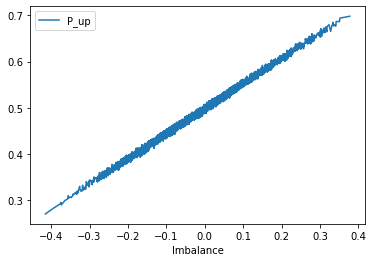

In [68]:
P_up_on_Imbalance_r.plot()

In [62]:
P_up_t = np.array([ [barrier_up,
                     function_test(market_move, barrier_up = barrier_up, barrier_down = 0.02)[0]] for barrier_up in [x/1000 for x in range(5,995,5)]])

In [71]:
P_down_t = np.array([ [barrier_down,
                     function_test(market_move, barrier_up = 0.1, barrier_down = barrier_down)[1]] for barrier_down in [x/1000 for x in range(5,995,5)]])

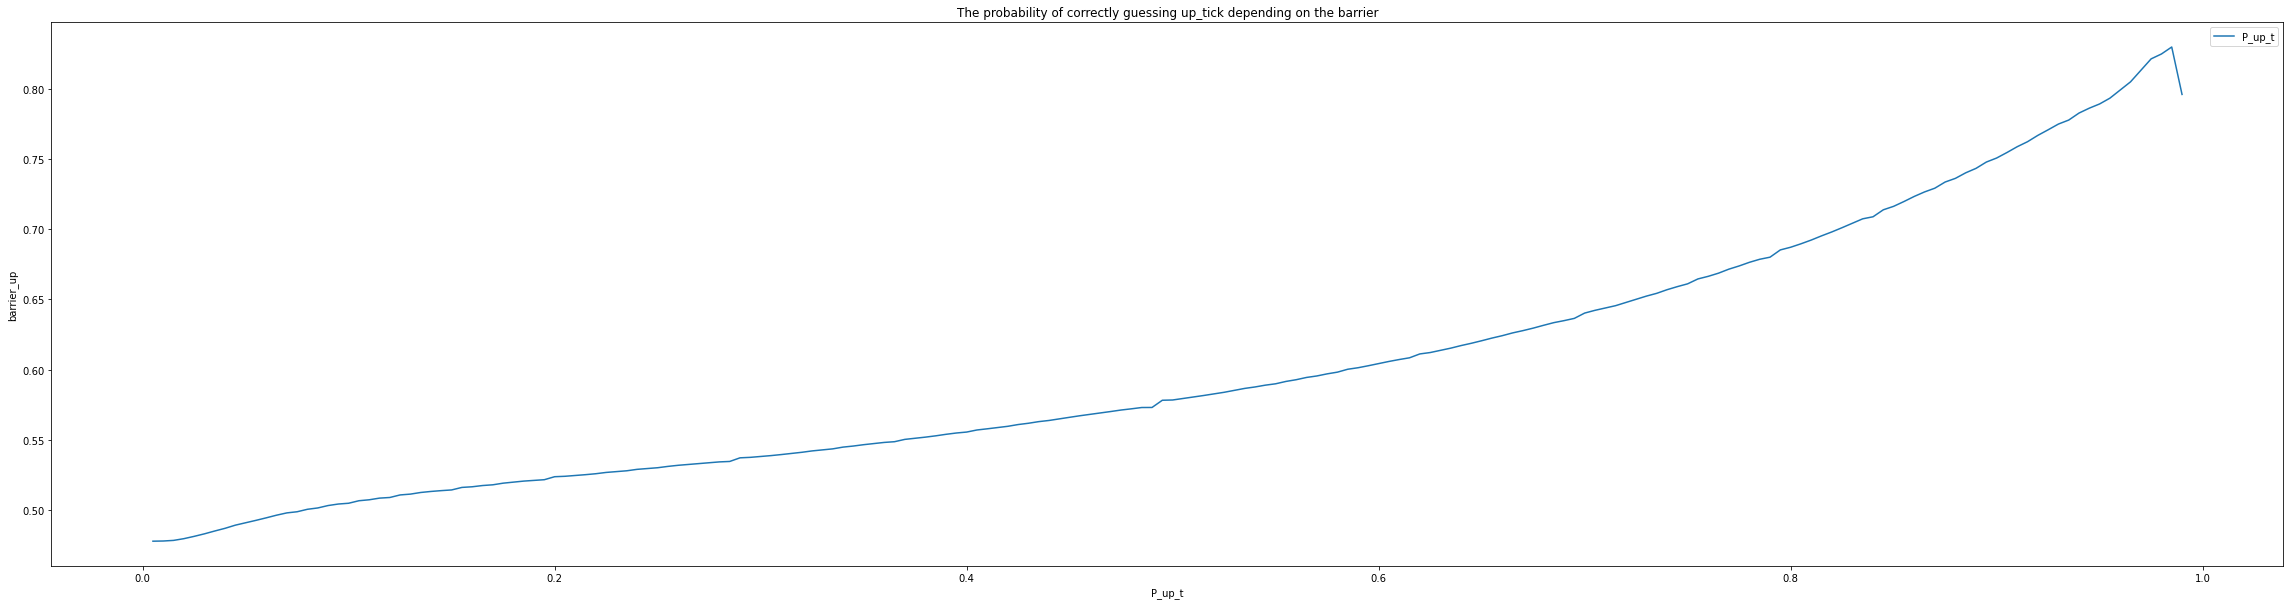

In [63]:
plt.figure(figsize=(40, 10))
plt.title('The probability of correctly guessing up_tick depending on the barrier')
plt.xlabel("P_up_t")
plt.ylabel("barrier_up")
plt.plot(P_up_t[:,0], P_up_t[:,1], label='P_up_t')
plt.legend()

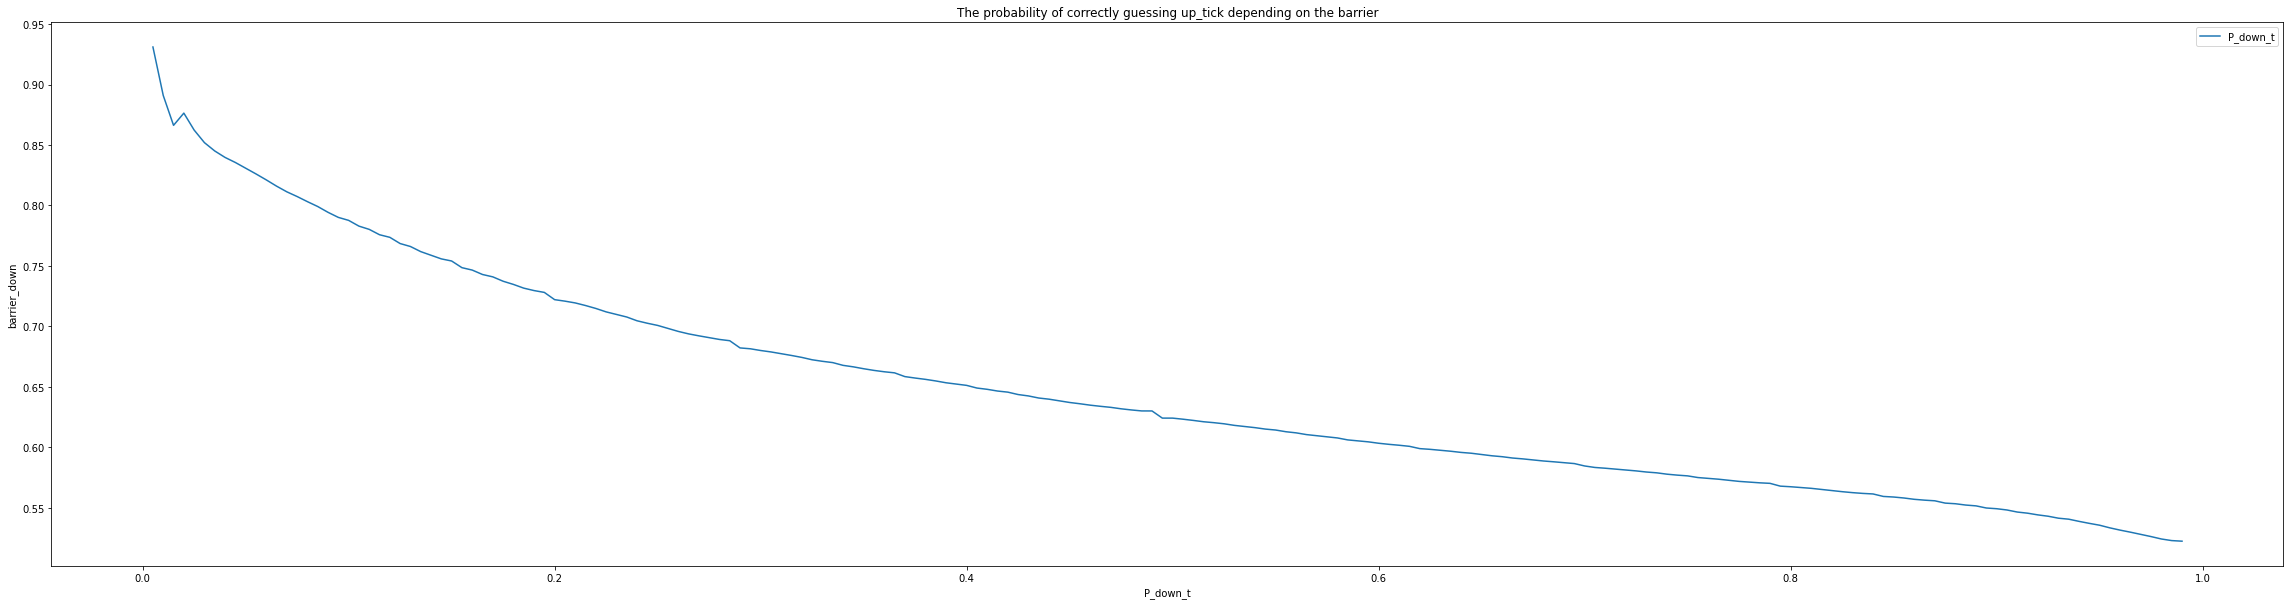

In [72]:
plt.figure(figsize=(40, 10))
plt.title('The probability of correctly guessing up_tick depending on the barrier')
plt.xlabel("P_down_t")
plt.ylabel("barrier_down")
plt.plot(P_down_t[:,0], P_down_t[:,1], label='P_down_t')
plt.legend()

## Creating a strategy

#### barrier-based signal generation

In [1110]:
price = (market_move['a_px_0'] + market_move['b_px_0']) / 2

In [1291]:
barrier_up = 0.80
barrier_down = 0.20
delay = 10
cost_per_unit_pos = 0.06
multipliers = 10_000

In [1292]:
price = price.loc[price.index.duplicated(keep = 'last')==False].loc[market_move.query('qtype == 1').index]
P_up_ = P_up.loc[P_up.index.duplicated(keep = 'last')==False].shift(delay).fillna(0)

In [1293]:
signal_buy = P_up_ > barrier_up
signal_sell = P_up_ < barrier_down

position = np.zeros(len(P_up_))
position[:] = np.nan
position[np.where(signal_sell)] = -1
position[np.where(signal_buy)] = 1
position[0] = 0

In [1294]:
position = np.array(pd.Series(position, index = P_up.loc[P_up.index.duplicated(keep = 'last')==False].index).fillna(method = 'ffill').loc[market_move.query('qtype == 1').index], dtype=np.float32)

In [1295]:
d_pos = np.concatenate([np.zeros(1),position[1:] - position[:-1]])

In [1296]:
costs = np.cumsum(abs(d_pos) * cost_per_unit_pos)

In [1297]:
d_cash = -d_pos * price * multipliers

In [1298]:
cash = np.cumsum(d_cash)

In [1299]:
# position[0] = 0

In [1300]:
equity = pd.DataFrame({'equity': (cash + position * price * multipliers - costs)}, index = price.index)

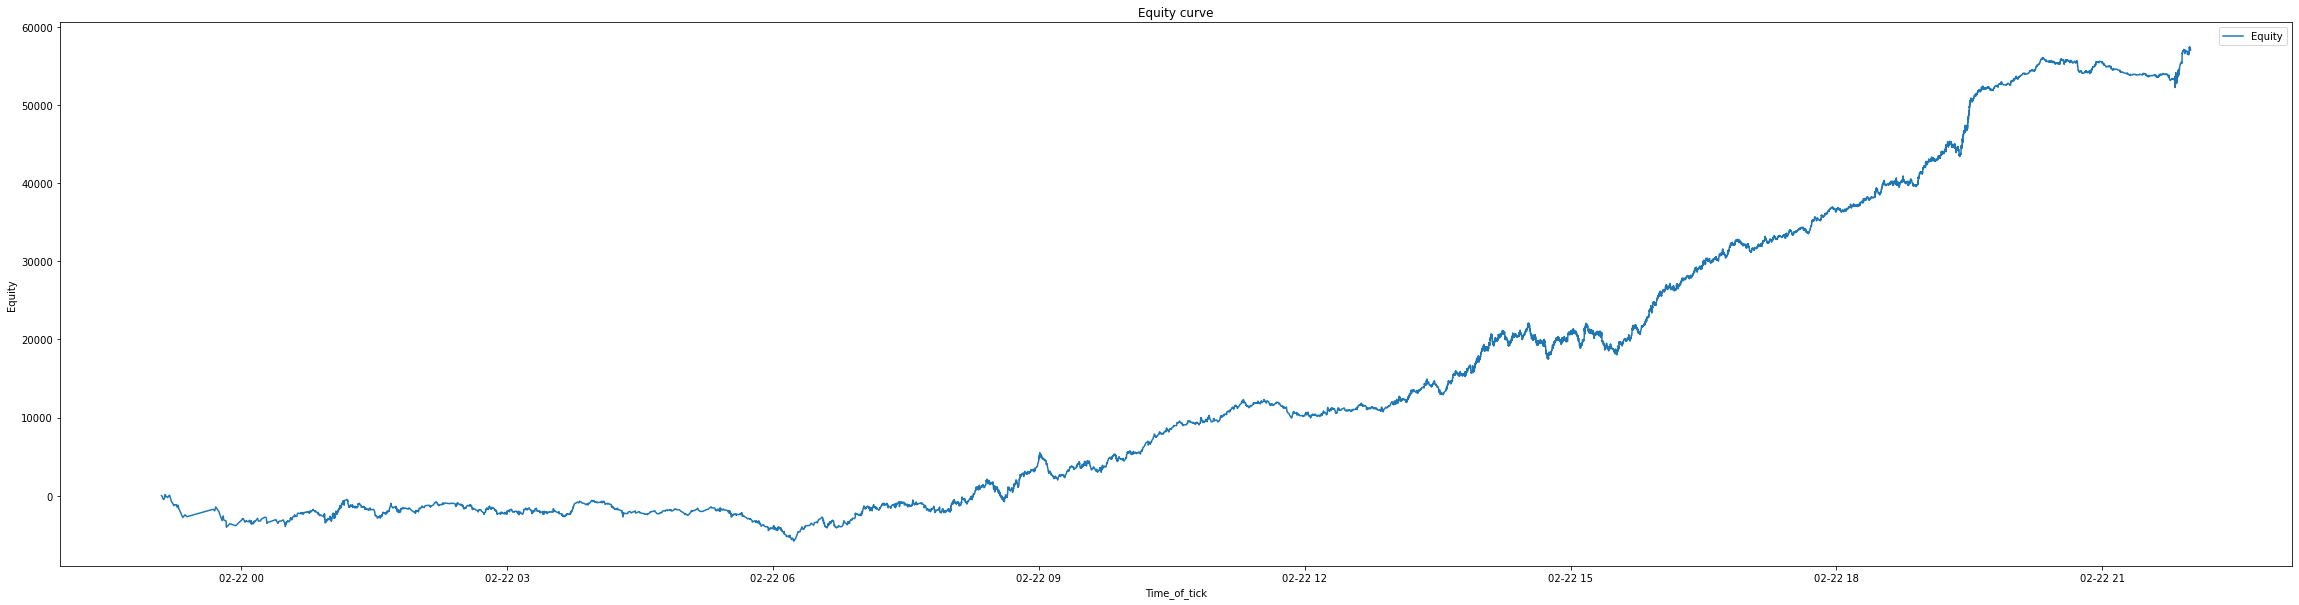

In [1302]:
plt.figure(figsize=(40, 10))
plt.title('Equity сurve')
plt.xlabel("Time_of_tick")
plt.ylabel("Equity")
plt.plot(equity - equity.iloc[0], label='Equity')
plt.legend()

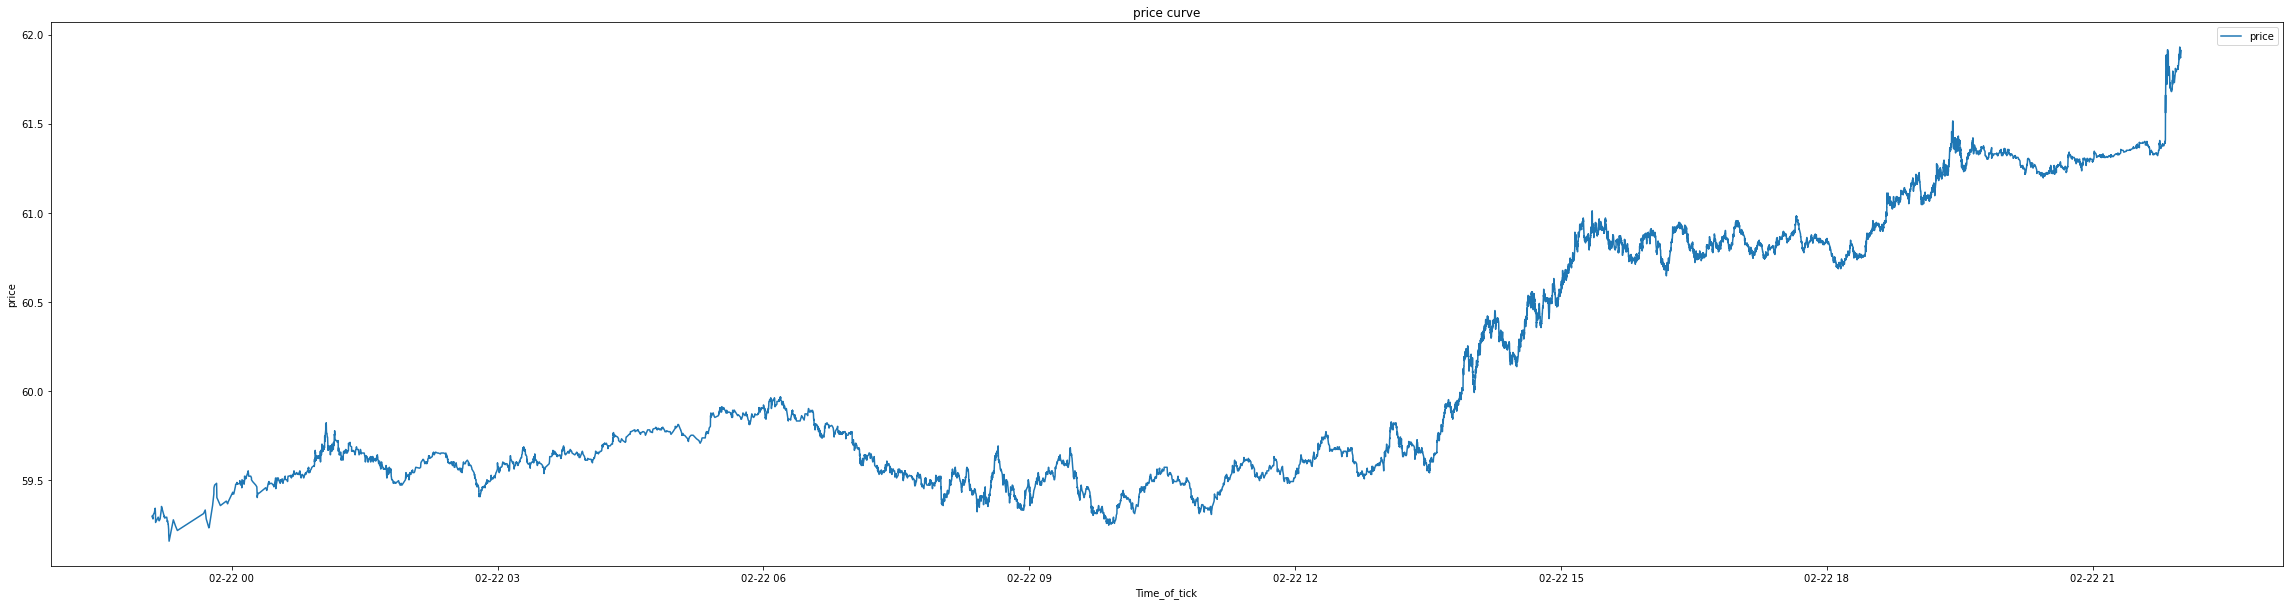

In [1324]:
plt.figure(figsize=(40, 10))
plt.title('price сurve')
plt.xlabel("Time_of_tick")
plt.ylabel("price")
plt.plot(price, label='price')
plt.legend()

In [1304]:
result = equity

## Sharp

In [1307]:
Daily_Return = result.pct_change(500)
Sharpe_Ratio = Daily_Return.mean() / Daily_Return.std()
print(f"My Sharpe Ratio was {Sharpe_Ratio} ")

My Sharpe Ratio was equity    0.802103
dtype: float64 


In [1322]:
Daily_Return = result.iloc[int(result.shape[0] * 0.5):].pct_change(500)
Sharpe_Ratio = Daily_Return.mean() / Daily_Return.std()
print(f"My Sharpe Ratio was {Sharpe_Ratio} ")

My Sharpe Ratio was equity    1.178512
dtype: float64 


In [1277]:
delta_2 = np.array([(P_up.index[i] - P_up.index[i-10]) for i in range(25, P_up.shape[0])]).mean()

In [1278]:
delta_2

Timedelta('0 days 00:00:00.235468496')

In [385]:
term = market_move.query('qtype == 1')
np.array([(term.index[i] - term.index[i-1]) for i in range(1, term.shape[0])]).mean()

Timedelta('0 days 00:00:04.352824372')

In [1306]:
np.array([(P_up.index[i] - P_up.index[i-1]) for i in range(1, P_up.shape[0])]).mean()

Timedelta('0 days 00:00:00.023547712')